1) Multi-regression output problem --> predict two labels: longitude and latitude

2) Re-write problem as multi-class problem through clustering
To define the classes, the last points per trip from the training data will be divided into clusters. When we have a large enough number of clusters, the clusters should be small enough to have their points close to their centroids. 

K-Means is a good approach as it minimizes the sum of squared distances within the cluster. Also it scales well to a large number of clusters. 

So the approach then predicts: **Probability of final destination of a trip being located in a specific cluster**

Steps:
- Get optimal number of clusters with help of interia
- Generate clusters with K-Means for each trip in training data
- Predict cluster for each trip in testing data
- Get centroids for each cluster 
- Calculate distance from points in cluster to centroid to evaluate

In [3]:
import os
import pandas as pd
import numpy as np
import datetime
from datetime import datetime
import time
import json
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import awswrangler as wr

In [4]:
import utils

In [5]:
train_data = wr.s3.read_parquet('s3://think-tank-casestudy/preprocessed_data/train_data_preprocess.parquet')
test_data = wr.s3.read_parquet('s3://think-tank-casestudy/preprocessed_data/test_data_preprocess.parquet')

In [6]:
train_data = utils.adjust_datatypes(train_data, True, True)
test_data = utils.adjust_datatypes(test_data, True, True)

In [7]:
def extract_lat_lon(data,column_):
    data[column_+'_LON'] = data[column_].apply(lambda value: value[0])    
    data[column_+'_LAT'] = data[column_].apply(lambda value: value[1])
    return data

In [8]:
train_data = extract_lat_lon(train_data,'START_POINT')
test_data = extract_lat_lon(test_data,'START_POINT')

train_data = extract_lat_lon(train_data,'DEST_POINT')
test_data = extract_lat_lon(test_data,'DEST_POINT')

In [9]:
stacked_DEST_POINT = np.vstack(train_data.DEST_POINT)

In [10]:
from sklearn.preprocessing import StandardScaler
stacked_DEST_POINT_scaled = StandardScaler().fit_transform(stacked_DEST_POINT)

In [11]:
train_data.shape[0] / 1000

1371.135

In [12]:
X = train_data[train_data.columns[-2:]]

In [13]:
#!pip install dask_ml

In [14]:
from sklearn.cluster import KMeans
import dask.array as da
from dask_ml import cluster

In [15]:
X_da = da.from_array(stacked_DEST_POINT_scaled)

In [ ]:
inertia_per_k = [(k, KMeans(n_clusters=k, init='k-means++', verbose=True, random_state=1).fit(X_da).inertia_)
  for k in range(1000,5000,1000)]

/Users/julia.hehl/opt/anaconda3/lib/python3.9/site-packages/dask/array/core.py:1638: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


Initialization complete
Iteration 0, inertia 3477.162924457387.
Iteration 1, inertia 2900.558550509185.
Iteration 2, inertia 2807.5740589754614.
Iteration 3, inertia 2770.381780229555.
Iteration 4, inertia 2746.557604947341.
Iteration 5, inertia 2731.8422681594634.
Iteration 6, inertia 2722.311914418679.
Iteration 7, inertia 2715.5861119767696.
Iteration 8, inertia 2711.159839495876.
Iteration 9, inertia 2706.8411099029304.
Iteration 10, inertia 2703.0154894310585.
Iteration 11, inertia 2700.169251550864.
Iteration 12, inertia 2696.2045880871588.
Iteration 13, inertia 2692.7727888987656.
Iteration 14, inertia 2690.6919964720078.
Iteration 15, inertia 2688.998838909226.
Iteration 16, inertia 2687.9033387115696.
Iteration 17, inertia 2686.858348823881.
Iteration 18, inertia 2686.171816894415.
Iteration 19, inertia 2685.5567844617053.
Iteration 20, inertia 2684.792417066567.
Iteration 21, inertia 2684.249554208098.
Iteration 22, inertia 2683.7735068961506.
Iteration 23, inertia 2683.52101

Iteration 12, inertia 2699.077916391439.
Iteration 13, inertia 2697.0223480066857.
Iteration 14, inertia 2694.847270816927.
Iteration 15, inertia 2692.4102988667564.
Iteration 16, inertia 2689.9598063744734.
Iteration 17, inertia 2687.7360417088494.
Iteration 18, inertia 2686.079384116847.
Iteration 19, inertia 2684.9469302047623.
Iteration 20, inertia 2684.199509802882.
Iteration 21, inertia 2683.61949612995.
Iteration 22, inertia 2682.79440723029.
Iteration 23, inertia 2681.8320943820645.
Iteration 24, inertia 2680.842406611294.
Iteration 25, inertia 2679.6044209452293.
Iteration 26, inertia 2679.074798237011.
Iteration 27, inertia 2678.884285149474.
Converged at iteration 27: center shift 4.1447086095238663e-05 within tolerance 0.00010000000000001269.
Initialization complete
Iteration 0, inertia 3438.4403351622077.
Iteration 1, inertia 2898.6106807143506.
Iteration 2, inertia 2802.6761888336514.
Iteration 3, inertia 2760.4205411635194.
Iteration 4, inertia 2736.7122900133727.
Iterat

/Users/julia.hehl/opt/anaconda3/lib/python3.9/site-packages/dask/array/core.py:1638: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


Initialization complete
Iteration 0, inertia 1401.719136191143.
Iteration 1, inertia 1175.5491981914665.
Iteration 2, inertia 1139.3401119828543.
Iteration 3, inertia 1123.6796331715436.
Iteration 4, inertia 1114.5085311684925.
Iteration 5, inertia 1108.4073879122932.
Iteration 6, inertia 1104.2868701565144.
Iteration 7, inertia 1100.8778701313877.
Iteration 8, inertia 1098.1946835438648.
Iteration 9, inertia 1096.5832864505076.
Iteration 10, inertia 1095.257809787292.
Iteration 11, inertia 1094.0358382679333.
Iteration 12, inertia 1092.7216868257954.
Iteration 13, inertia 1091.7712864933617.
Iteration 14, inertia 1091.109711908192.
Iteration 15, inertia 1090.5329849331313.
Iteration 16, inertia 1089.846720155251.
Iteration 17, inertia 1089.3598482169366.
Iteration 18, inertia 1088.9858234352537.
Iteration 19, inertia 1088.5981757904378.
Iteration 20, inertia 1088.3316526166832.
Iteration 21, inertia 1088.1124686512237.
Iteration 22, inertia 1087.9090992211118.
Iteration 23, inertia 10

Iteration 16, inertia 1096.09949393483.
Iteration 17, inertia 1095.436442490404.
Iteration 18, inertia 1094.8884711279916.
Iteration 19, inertia 1094.48916967881.
Iteration 20, inertia 1094.2497752172678.
Iteration 21, inertia 1094.0618921647667.
Iteration 22, inertia 1093.875204718544.
Iteration 23, inertia 1093.6875876506826.
Iteration 24, inertia 1093.4959035922946.
Iteration 25, inertia 1093.3527414879297.
Converged at iteration 25: center shift 7.221514120613333e-05 within tolerance 0.00010000000000001269.
Initialization complete
Iteration 0, inertia 1400.2581716059376.
Iteration 1, inertia 1173.6229199841584.
Iteration 2, inertia 1136.8010805138567.
Iteration 3, inertia 1121.1573484799153.
Iteration 4, inertia 1112.665236504835.
Iteration 5, inertia 1107.079533314243.
Iteration 6, inertia 1103.2945771185691.
Iteration 7, inertia 1100.513891000106.
Iteration 8, inertia 1098.1090949981963.
Iteration 9, inertia 1096.0930781664676.
Iteration 10, inertia 1094.6000962346798.
Iteration 

/Users/julia.hehl/opt/anaconda3/lib/python3.9/site-packages/dask/array/core.py:1638: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


Initialization complete
Iteration 0, inertia 816.8138953306714.
Iteration 1, inertia 677.4157763424057.
Iteration 2, inertia 656.1130720880509.
Iteration 3, inertia 646.795300451299.
Iteration 4, inertia 641.575957391061.
Iteration 5, inertia 638.386592588647.
Iteration 6, inertia 635.9801383480619.
Iteration 7, inertia 634.4062285679126.
Iteration 8, inertia 632.9382264186561.
Iteration 9, inertia 631.8143660929973.
Iteration 10, inertia 631.0008703321822.
Iteration 11, inertia 630.451827747095.
Iteration 12, inertia 629.991596104894.
Iteration 13, inertia 629.5669882369061.
Iteration 14, inertia 629.1590245562356.
Iteration 15, inertia 628.7385736562769.
Iteration 16, inertia 628.3625707974818.
Iteration 17, inertia 628.0309905316824.
Iteration 18, inertia 627.8384131921839.
Iteration 19, inertia 627.6796544884962.
Iteration 20, inertia 627.5092186471225.
Iteration 21, inertia 627.3422442929354.
Iteration 22, inertia 627.2095935556945.
Iteration 23, inertia 627.1033812724529.
Iterati

Iteration 10, inertia 631.6756269983301.
Iteration 11, inertia 631.0930451922477.
Iteration 12, inertia 630.5928265219949.
Iteration 13, inertia 630.1566301012649.
Iteration 14, inertia 629.7908158275344.
Iteration 15, inertia 629.5861031438668.
Iteration 16, inertia 629.4227288662265.
Iteration 17, inertia 629.2961274586263.
Iteration 18, inertia 629.1620492585082.
Iteration 19, inertia 629.023928382323.
Iteration 20, inertia 628.9372427456501.
Iteration 21, inertia 628.8511856853077.
Iteration 22, inertia 628.7470006426769.
Iteration 23, inertia 628.6277651642599.
Iteration 24, inertia 628.5481300372114.
Iteration 25, inertia 628.4804602915133.
Converged at iteration 25: center shift 9.046838666048658e-05 within tolerance 0.00010000000000001269.
Initialization complete
Iteration 0, inertia 813.2370746621507.
Iteration 1, inertia 678.4581054573766.
Iteration 2, inertia 657.6203246815367.
Iteration 3, inertia 649.0936006427985.
Iteration 4, inertia 644.1947253856201.
Iteration 5, inert

In [ ]:
random.seed(5)

In [30]:
kmeans = KMeans(n_clusters = 1000, 
                init ='k-means++', verbose=True,
                random_state=1
               )
X['cluster_label'] = kmeans.fit_predict(X_da)
centers = kmeans.cluster_centers_ 
X.head(10)

/Users/julia.hehl/opt/anaconda3/lib/python3.9/site-packages/dask/array/core.py:1638: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


Initialization complete
Iteration 0, inertia 3477.162924457387.
Iteration 1, inertia 2900.558550509185.
Iteration 2, inertia 2807.5740589754605.
Iteration 3, inertia 2770.381780229555.
Iteration 4, inertia 2746.557604947341.
Iteration 5, inertia 2731.8422681594634.
Iteration 6, inertia 2722.31191441868.
Iteration 7, inertia 2715.586111976769.
Iteration 8, inertia 2711.159839495875.
Iteration 9, inertia 2706.84110990293.
Iteration 10, inertia 2703.015489431058.
Iteration 11, inertia 2700.169251550864.
Iteration 12, inertia 2696.2045880871583.
Iteration 13, inertia 2692.7727888987647.
Iteration 14, inertia 2690.6919964720073.
Iteration 15, inertia 2688.9988389092277.
Iteration 16, inertia 2687.90333871157.
Iteration 17, inertia 2686.8583488238814.
Iteration 18, inertia 2686.171816894415.
Iteration 19, inertia 2685.5567844617053.
Iteration 20, inertia 2684.7924170665665.
Iteration 21, inertia 2684.2495542080974.
Iteration 22, inertia 2683.77350689615.
Iteration 23, inertia 2683.5210117603

Iteration 12, inertia 2699.0779163914394.
Iteration 13, inertia 2697.0223480066857.
Iteration 14, inertia 2694.8472708169256.
Iteration 15, inertia 2692.4102988667555.
Iteration 16, inertia 2689.959806374474.
Iteration 17, inertia 2687.736041708849.
Iteration 18, inertia 2686.079384116847.
Iteration 19, inertia 2684.946930204762.
Iteration 20, inertia 2684.199509802883.
Iteration 21, inertia 2683.6194961299507.
Iteration 22, inertia 2682.794407230289.
Iteration 23, inertia 2681.8320943820645.
Iteration 24, inertia 2680.842406611294.
Iteration 25, inertia 2679.6044209452284.
Iteration 26, inertia 2679.074798237011.
Iteration 27, inertia 2678.884285149474.
Converged at iteration 27: center shift 4.144708609523759e-05 within tolerance 0.00010000000000001269.
Initialization complete
Iteration 0, inertia 3438.4403351622077.
Iteration 1, inertia 2898.6106807143497.
Iteration 2, inertia 2802.6761888336523.
Iteration 3, inertia 2760.42054116352.
Iteration 4, inertia 2736.7122900133727.
Iterati

/var/folders/98/blj_ctsx7kj90yq1wpxpkthh0000gn/T/ipykernel_3079/807102351.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['cluster_label'] = kmeans.fit_predict(X_da)


,DEST_POINT_LON,DEST_POINT_LAT,cluster_label
0,-8.630838,41.154489,208
1,-8.665740,41.170671,359
2,-8.615970,41.140530,304
3,-8.607996,41.142915,343
4,-8.687268,41.178087,653
5,-8.578224,41.160717,523
6,-8.603973,41.142816,487
7,-8.624700,41.161554,393
8,-8.589402,41.163309,714
9,-8.604594,41.134158,859


(array([200067., 155386., 137479., 132929., 162204., 100639., 150026.,
        119267., 106779., 106359.]),
 array([  0. ,  99.9, 199.8, 299.7, 399.6, 499.5, 599.4, 699.3, 799.2,
        899.1, 999. ]),
 <BarContainer object of 10 artists>)

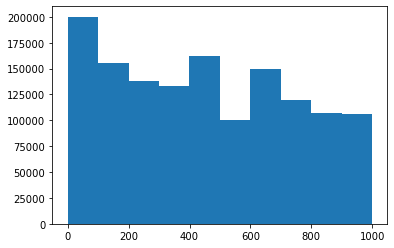

In [35]:
plt.hist(X.cluster_label)

In [36]:
X_test = test_data[test_data.columns[-2:]]

In [40]:
X_test_scaled =StandardScaler().fit_transform(np.array(X_test))

In [43]:
X_da_test = da.from_array(X_test_scaled)

In [44]:
X_test['CLUSTER_LABEL'] = kmeans.predict(X_da_test)

/var/folders/98/blj_ctsx7kj90yq1wpxpkthh0000gn/T/ipykernel_3079/3942008030.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['cluster_label'] = kmeans.predict(X_da_test)


In [52]:
train_data['CLUSTER_LABEL'] = X['CLUSTER_LABEL']
test_data['CLUSTER_LABEL'] = X_test['CLUSTER_LABEL']

In [54]:
wr.s3.to_parquet(df=train_data, path='s3://think-tank-casestudy/preprocessed_data/train_data_clustered.parquet')
wr.s3.to_parquet(df=test_data, path='s3://think-tank-casestudy/preprocessed_data/test_data_clustered.parquet')

{'paths': ['s3://think-tank-casestudy/preprocessed_data/test_data_clustered.parquet'],
 'partitions_values': {}}